In [40]:
from datetime import datetime

import pandas
import matplotlib.pyplot as plt
import seaborn as sns
from fbprophet import Prophet
from sklearn.metrics import mean_absolute_percentage_error as mape
import numpy as np
from scipy.stats import gaussian_kde

%matplotlib inline
%config InlineBackend.figure_format = "retina"

sns.set(rc={"figure.figsize" : (20, 10)})
sns.set_style("ticks")

In [41]:
df = pandas.read_csv("troon_instagram_clean_post_data.csv")
df = df.set_index("id")
df = df[["post_month", "post_day", "post_year", "days_since_previous_release", "release_post"]].copy()
df["month"] = df["post_month"].apply(lambda x : datetime.strptime(x, '%B').month)
df = df.rename(columns={"post_year" : "year", "post_day" : "day"})
df["date"] = pandas.to_datetime(df[["year", "month", "day"]])
del df["month"]
del df["day"]
del df["year"]
del df["post_month"]
df

,days_since_previous_release,release_post,date
id,,,
50,NaN,False,2016-02-15
123,NaN,False,2016-02-15
173,NaN,False,2016-02-15
156,NaN,False,2016-02-15
133,NaN,False,2016-02-15
...,...,...,...
316,5.0,True,2021-11-04
317,6.0,True,2021-11-10
318,7.0,True,2021-11-17


In [42]:
df.query("release_post == True & days_since_previous_release.isnull()")

,days_since_previous_release,release_post,date
id,,,


In [43]:
df = df[df["days_since_previous_release"].notnull()].copy()

In [44]:
df = df[df["release_post"] == True].copy()

In [45]:
df["days_until_next_release"] = df["days_since_previous_release"].shift(-1, fill_value=0)

In [46]:
last_release = df[df["days_until_next_release"] == 0].iloc[0]["date"]
last_release

Timestamp('2021-11-29 00:00:00')

In [47]:
df = df[df["days_until_next_release"] != 0].copy()

In [48]:
df

,days_since_previous_release,release_post,date,days_until_next_release
id,,,,
183,0.0,True,2017-02-17,9.0
197,9.0,True,2017-02-26,20.0
109,20.0,True,2017-03-18,6.0
57,6.0,True,2017-03-24,6.0
196,6.0,True,2017-03-30,7.0
...,...,...,...,...
312,2.0,True,2021-10-30,5.0
316,5.0,True,2021-11-04,6.0
317,6.0,True,2021-11-10,7.0


In [49]:
df["weekday"] = df["date"].apply(lambda x : x.weekday())
df = pandas.get_dummies(df, columns=["weekday"], prefix="weekday")
df

,days_since_previous_release,release_post,date,days_until_next_release,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
id,,,,,,,,,,,
183,0.0,True,2017-02-17,9.0,0,0,0,0,1,0,0
197,9.0,True,2017-02-26,20.0,0,0,0,0,0,0,1
109,20.0,True,2017-03-18,6.0,0,0,0,0,0,1,0
57,6.0,True,2017-03-24,6.0,0,0,0,0,1,0,0
196,6.0,True,2017-03-30,7.0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
312,2.0,True,2021-10-30,5.0,0,0,0,0,0,1,0
316,5.0,True,2021-11-04,6.0,0,0,0,1,0,0,0
317,6.0,True,2021-11-10,7.0,0,0,1,0,0,0,0


---

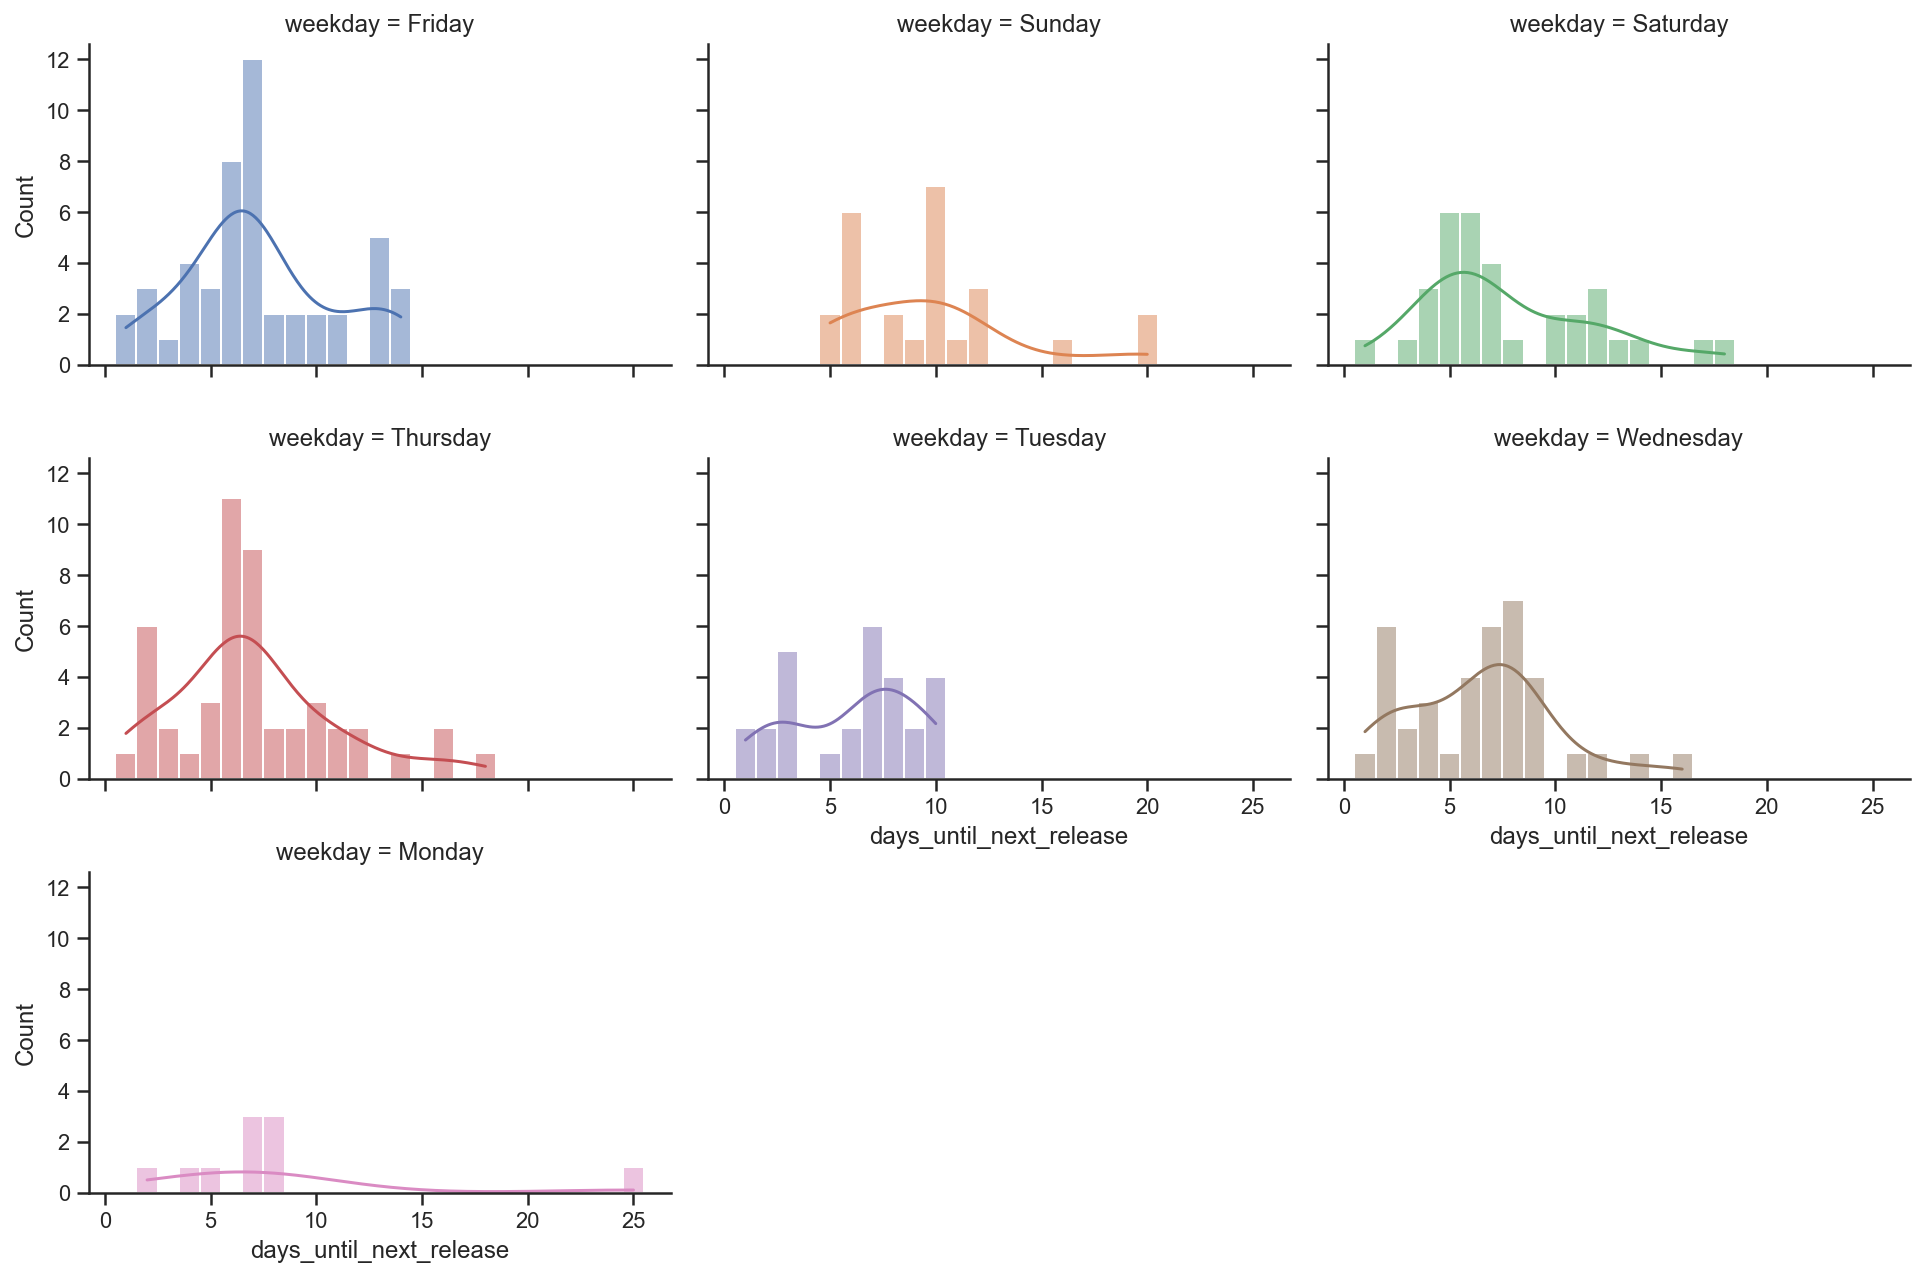

In [50]:
temp = df.copy()
temp["weekday"] = df["date"].apply(lambda x : x.strftime("%A"))

g = sns.FacetGrid(temp, col="weekday", col_wrap=3, hue="weekday", sharex=True, sharey=True, aspect=1.5, height=3)
g.map(sns.histplot, "days_until_next_release", discrete=True, kde=True)
plt.show()

---

In [51]:
train_df = df[0:int(len(df) * 0.85)].copy()
test_df = df[~df.index.isin(train_df.index)].copy()
print(len(train_df), len(test_df))

196 35


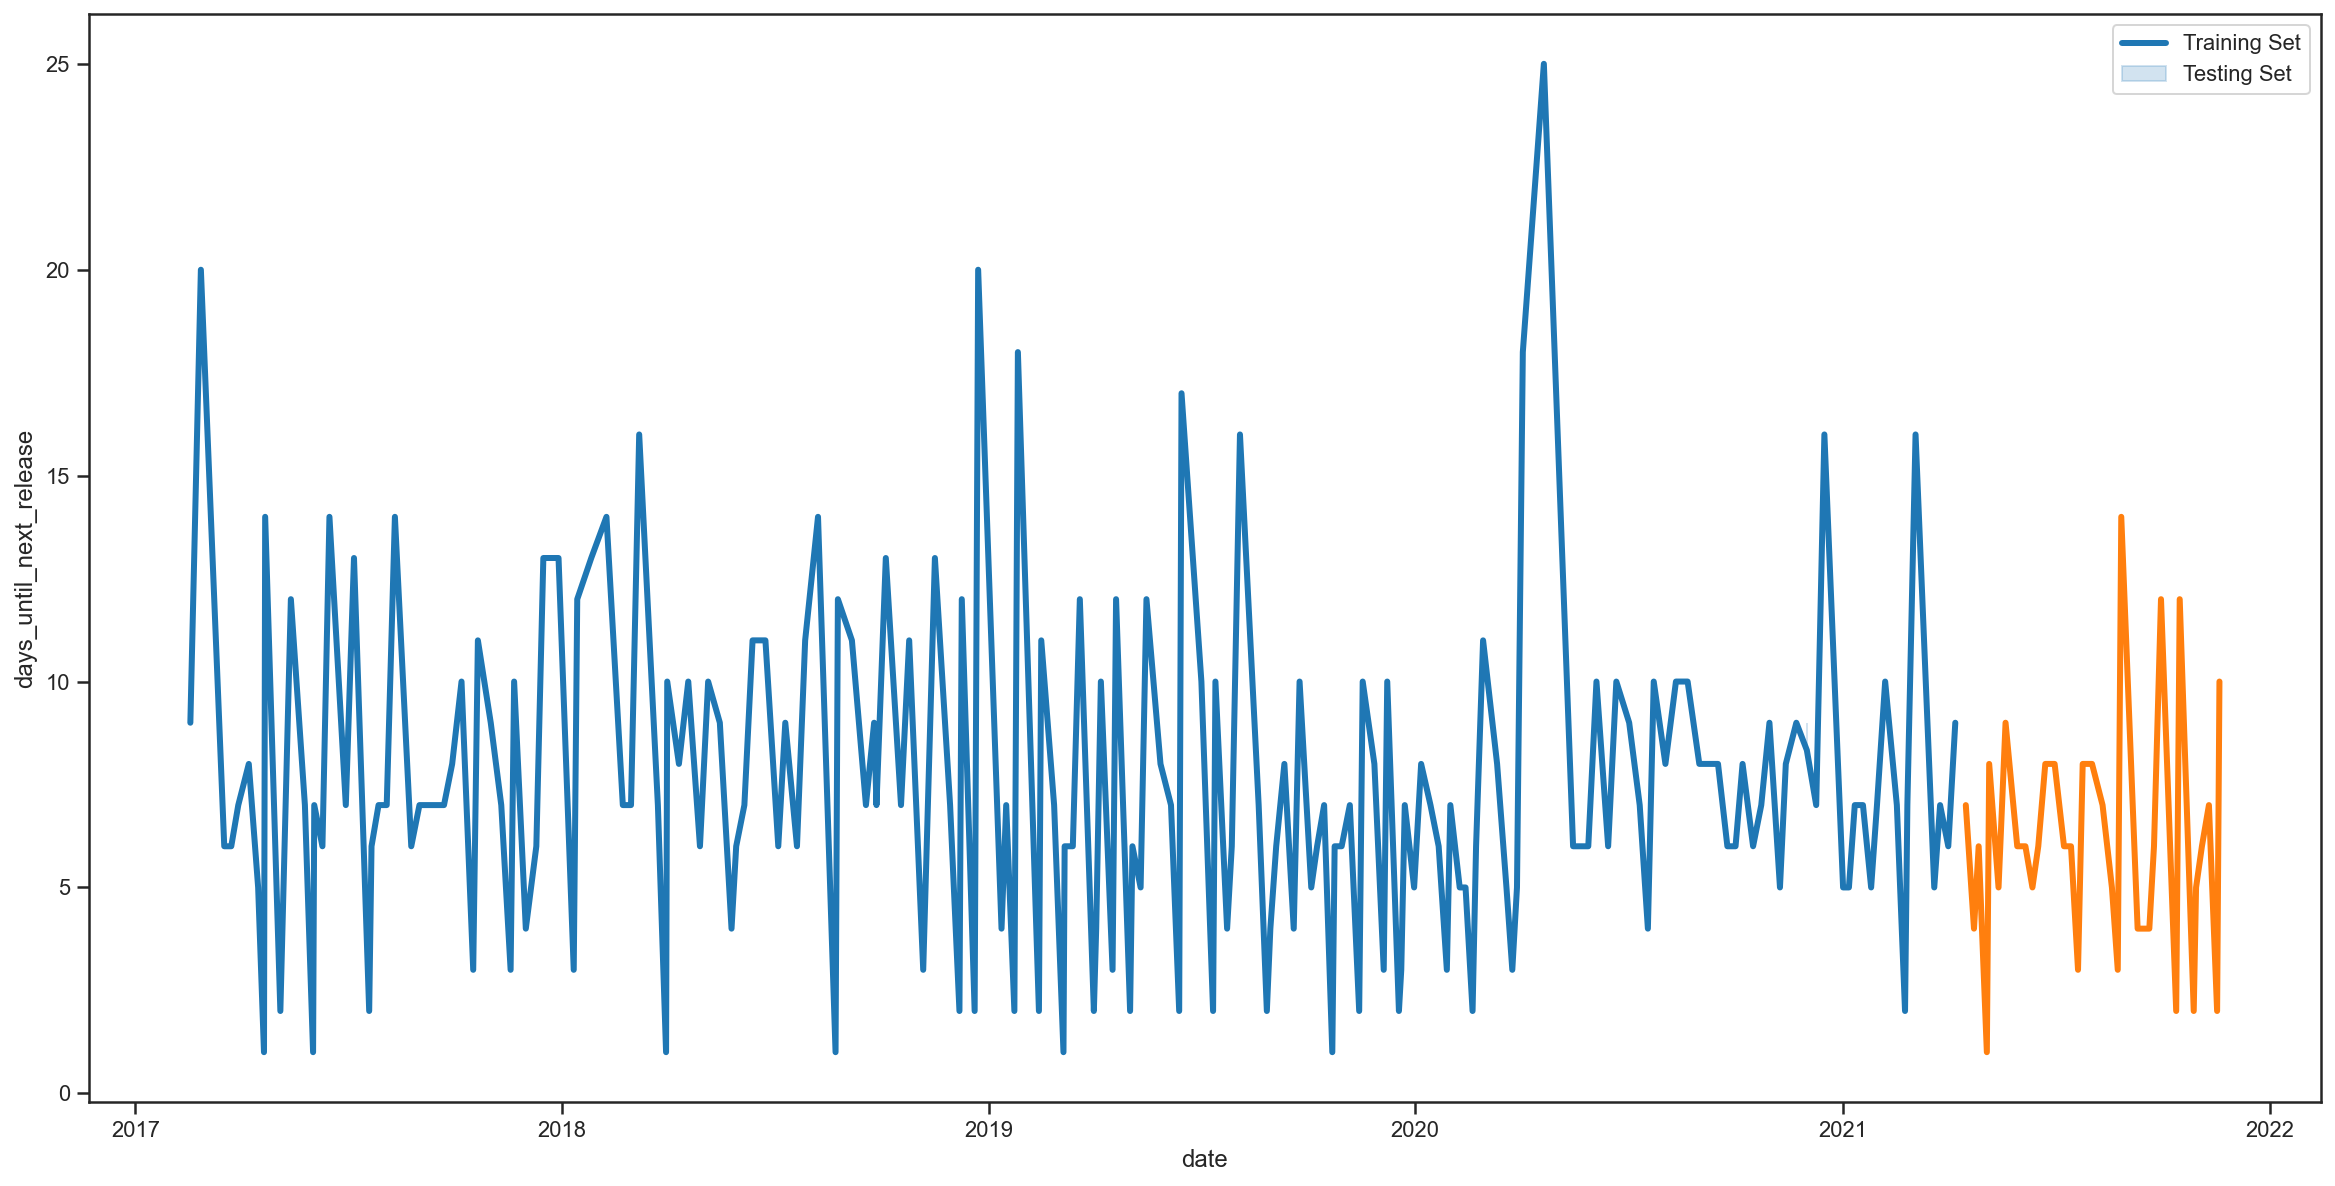

In [52]:
ax = sns.lineplot(data=train_df, x="date", y="days_until_next_release", color="tab:blue", linewidth=3)
sns.lineplot(data=test_df, x="date", y="days_until_next_release", color="tab:orange", linewidth=3, ax=ax)
ax.legend(["Training Set", "Testing Set"])
plt.show()

In [53]:
train_df = train_df.rename(columns={"date" : "ds", "days_until_next_release" : "y"})
test_df = test_df.rename(columns={"date" : "ds", "days_until_next_release" : "y"})

In [54]:
# see also: https://facebook.github.io/prophet/docs/uncertainty_intervals.html
# help(Prophet)

In [55]:
m = Prophet(yearly_seasonality=False, weekly_seasonality=False, daily_seasonality=False)
m.add_regressor("weekday_0")
m.add_regressor("weekday_1")
m.add_regressor("weekday_2")
m.add_regressor("weekday_3")
m.add_regressor("weekday_4")
m.add_regressor("weekday_5")
m.add_regressor("weekday_6")
m.add_country_holidays(country_name="US")

In [56]:
m.fit(train_df[["ds", "y"] + [c for c in train_df.columns if c.startswith("weekday_")]])

Initial log joint probability = -4.82579


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      86       268.695   1.22824e-06        104.07   1.241e-08       0.001      166  LS failed, Hessian reset 
      99       268.695   4.46004e-08        94.194      0.4497      0.4497      182   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     107       268.695   8.98945e-09       107.748      0.2626      0.2626      192   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


In [57]:
predictions = m.predict(test_df[["ds"] + [c for c in test_df.columns if c.startswith("weekday_")]])
predictions = predictions.merge(test_df[["ds", "y"]], on="ds", how="left")

In [58]:
predictions = predictions[["ds", "y", "yhat", "yhat_lower", "yhat_upper"]].copy()

In [59]:
predictions = predictions.set_index("ds")

In [60]:
predictions = predictions.round(0)

In [61]:
mape(predictions["y"], predictions["yhat"])

0.7042063492063492

In [62]:
mape(predictions["y"], predictions["yhat_lower"])

0.5489909297052153

In [63]:
mape(predictions["y"], predictions["yhat_upper"])

1.6538095238095238

In [64]:
predictions

,y,yhat,yhat_lower,yhat_upper
ds,,,,
2021-04-16,7.0,7.0,2.0,12.0
2021-04-23,4.0,7.0,2.0,12.0
2021-04-27,6.0,6.0,1.0,11.0
2021-05-04,1.0,6.0,1.0,11.0
2021-05-06,8.0,7.0,2.0,12.0
2021-05-14,5.0,7.0,3.0,12.0
2021-05-20,9.0,7.0,2.0,12.0
2021-05-30,6.0,10.0,5.0,15.0
2021-06-06,6.0,10.0,5.0,15.0


In [65]:
last_release = pandas.DataFrame([{"ds" : last_release}])
last_release["weekday"] = last_release["ds"].apply(lambda x : x.weekday())
last_release = pandas.get_dummies(last_release, columns=["weekday"], prefix="weekday")
for w in range(0, 7):
    col_name = "weekday_{}".format(w)
    if col_name not in last_release.columns:
        last_release[col_name] = 0
last_release

,ds,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,2021-11-29,1,0,0,0,0,0,0


In [66]:
last_release = last_release[sorted(last_release.columns)]

In [67]:
m.predict(last_release)[["ds", "yhat", "yhat_lower", "yhat_upper"]].round(0)

,ds,yhat,yhat_lower,yhat_upper
0,2021-11-29,8.0,3.0,13.0
